## Práctica 1 de Laboratorio de Computación Adiabática: Optimización Cuántica: QUBO con restricciones

Ignacio López y Jaime Bielza

# Pips

In [ ]:
#!pip install networkx dimod dwave-ocean-sdk matplotlib dwave-neal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.5/165.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.0 MB/s eta 0:00:00


# Parte 1: Planteamiento del problema

## Planteamiento del problema Max-Cut

Vamos a trabajar el problema **Max-Cut** empleando modelos QUBO (Quadratic Unconstrained Binary Optimization). El objetivo es dividir los nodos de un grafo en dos conjuntos tal que el **peso total de las aristas cortadas** (las que unen nodos de diferentes conjuntos) sea máximo.

La formulación energética (a minimizar) del Max-Cut es:

$$
E(x) = - \sum_{(i, j) \in E} w_{i,j} \left( x_i + x_j - 2 x_i x_j \right)
$$

donde $x_i \in \{0, 1\}$ indica la pertenencia de cada nodo a un conjunto y $w_{i,j}$ es el peso de la arista $(i, j)$.


## Celda 1: Imports y configuración inicial

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

## Imports y configuración inicial

Importamos las librerías necesarias:
- **networkx**: para manipulación de grafos.
- **matplotlib**: para visualización.
- **numpy**: para operaciones numéricas.
- **random**: para generación de números aleatorios.

Con estas librerías se establece la infraestructura para modelar y resolver el problema de Max-Cut.


## Celda 2: Definición del grafo ponderado y visualización

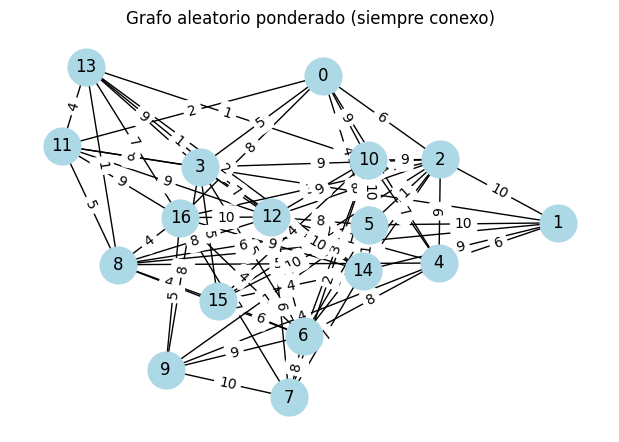

In [ ]:
# Parámetros del grafo
n = 17  # número de nodos
probabilidad_arista = 0.5

# Repite hasta que sea conexo (todos los nodos conectados)
while True:
    G = nx.erdos_renyi_graph(n, probabilidad_arista)
    if nx.is_connected(G):
        break

for u, v in G.edges():
    G[u][v]['weight'] = random.randint(1, 10)

# Visualiza el grafo con pesos
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(6,4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Grafo aleatorio ponderado (siempre conexo)")
plt.show()


## Definición y visualización del grafo

Se genera un **grafo conexo aleatorio** utilizando el modelo Erdős–Rényi y se asignan pesos aleatorios a las aristas para simular un entorno realista.

Visualizamos el grafo para entender su estructura antes de la optimización.


## Celda 3: Explicación conceptual y fórmula Max-Cut QUBO

## Análisis matemático del QUBO para Max-Cut

La función de energía QUBO para el problema Max-Cut está dada por:

$$
E(x) = - \sum_{(i, j) \in E} w_{i,j} \left( x_i + x_j - 2 x_i x_j \right)
$$

Este problema se representa mediante un diccionario QUBO con términos lineales $((i, i))$ y cuadráticos $((i, j))$, permitiendo su solución por métodos clásicos y cuánticos.


## Celda 4: Diccionario QUBO para Max-Cut puro

In [ ]:
import dimod
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def maxcut_qubo(G):
    Q = {}
    for u, v, w in G.edges(data='weight'):
        Q[(u, u)] = Q.get((u, u), 0) + w
        Q[(v, v)] = Q.get((v, v), 0) + w
        Q[(u, v)] = Q.get((u, v), 0) - 2 * w
    return Q


# Cálculo QUBO
qubo = maxcut_qubo(G)

# Tabla de los primeros términos QUBO (más visual)
df_qubo = pd.DataFrame(
    [(k[0], k[1] if len(k)>1 else k[0], v) for k,v in list(qubo.items())[:10]],
    columns=["Nodo i","Nodo j","Valor"]
)
print("Primeros términos QUBO:")
display(df_qubo)


Primeros términos QUBO:


,Nodo i,Nodo j,Valor
0,0,0,38
1,2,2,65
2,0,2,-12
3,3,3,61
4,0,3,-10
5,4,4,53
6,0,4,-8
7,5,5,57
8,0,5,-8
9,10,10,60


## Construcción del diccionario QUBO

Se crea un diccionario QUBO donde cada clave $(i, j)$ apunta a un coeficiente que codifica la función energía del Max-Cut.

Así, el problema queda codificado para ser resuelto computacionalmente.


# Parte 2: Restricciones adicionales

## Restricciones adicionales: Must-Link, Cannot-Link y balanceo

Para hacer el problema más realista se añaden restricciones:

- **Must-Link**: pares de nodos que deben pertenecer a la misma partición.
- **Cannot-Link**: pares que deben estar en particiones diferentes.
- **Balanceo**: penalización para evitar particiones muy desbalanceadas.

Estas restricciones se introducen como penalizaciones en el QUBO.


## Celda 1 – Seleccionar restricciones aleatorias

In [ ]:
# Selección de restricciones Must-Link y Cannot-Link sobre el grafo existente G

pares = list(G.edges())
random.shuffle(pares)

num_must_link = 2
num_cannot_link = 2

must_link_pairs = pares[:num_must_link]
cannot_link_pairs = pares[num_must_link:num_must_link+num_cannot_link]

print("Restricciones Must-Link:", must_link_pairs)
print("Restricciones Cannot-Link:", cannot_link_pairs)


Restricciones Must-Link: [(3, 9), (2, 14)]
Restricciones Cannot-Link: [(7, 9), (12, 16)]


## Selección aleatoria de restricciones

Se seleccionan parejas de nodos de forma aleatoria para aplicar:

- restricciones Must-Link, y
- restricciones Cannot-Link.

Esto permite analizar el efecto de las restricciones sobre la solución.


## Celda 2 – Función para añadir restricciones al QUBO

In [ ]:
def add_constraints(Q, must_link, cannot_link, A, B):
    """
    Agrega restricciones Must-Link y Cannot-Link al modelo QUBO existente.
    Parámetros:
      - Q: diccionario QUBO inicial
      - must_link: lista de pares (i,j) que deben estar en la misma partición
      - cannot_link: lista de pares (i,j) que deben estar en distintas particiones
      - A, B: penalizaciones de cada restricción
    """
    Q_mod = Q.copy()

    # Must-Link → penaliza si xi != xj → agrega (xi - xj)^2
    for (u, v) in must_link:
        Q_mod[(u, u)] = Q_mod.get((u, u), 0) + A
        Q_mod[(v, v)] = Q_mod.get((v, v), 0) + A
        Q_mod[(u, v)] = Q_mod.get((u, v), 0) - 2 * A

    # Cannot-Link → penaliza si xi == xj → agrega (1 - xi - xj + 2xi xj)
    for (u, v) in cannot_link:
        Q_mod[(u, u)] = Q_mod.get((u, u), 0) + B
        Q_mod[(v, v)] = Q_mod.get((v, v), 0) + B
        Q_mod[(u, v)] = Q_mod.get((u, v), 0) + 2 * B

    return Q_mod


## Incorporación de restricciones en el modelo QUBO

### Restricción Must-Link

Penaliza cuando $x_i \neq x_j$ para el par $(i, j)$:

$$
A \sum_{(i, j) \in M} (x_i - x_j)^2
$$

Expandiendo:

$$
(x_i - x_j)^2 = x_i + x_j - 2 x_i x_j
$$

### Restricción Cannot-Link

Penaliza cuando $x_i = x_j$ para el par $(i, j)$:

$$
B \sum_{(i, j) \in C} \left(1 - (x_i - x_j)^2 \right)
$$

Expandiendo:

$$
1 - (x_i - x_j)^2 = 1 - x_i - x_j + 2 x_i x_j
$$

### Modelo QUBO con restricciones

$$
E_{\text{total}}(x) = -\sum_{(i, j) \in E} w_{i,j} (x_i + x_j - 2 x_i x_j) + A \sum_{(i, j) \in M} (x_i + x_j - 2 x_i x_j) + B \sum_{(i, j) \in C} (1 - x_i - x_j + 2 x_i x_j)
$$


## Celda 3 – Función de restricción de balanceo

In [ ]:
def add_balance_constraint(Q, nodes, A):
    Q_mod = Q.copy()
    n = len(nodes)
    # Desarrollo exacto de (sum x_i - n/2)^2:
    # = sum_i x_i - n sum_i x_i + 2 sum_{i<j} x_i x_j + términos constantes (omitidos)
    for i in nodes:
        # Diagonal: 1 - n/2*2 = 1 - n + n^2/4 (constante irrelevante se omite)
        Q_mod[(i, i)] = Q_mod.get((i, i), 0) + A * (1 - n)
    for i in nodes:
        for j in nodes:
            if i < j:  # Solo una vez por par (i,j)
                Q_mod[(i, j)] = Q_mod.get((i, j), 0) + 2 * A
    return Q_mod




## Restricción de balanceo de particiones

Para penalizar el desequilibrio en el tamaño de las particiones:

$$
C \left( \sum_i x_i - \frac{n}{2} \right)^2
$$

Expandiendo:

$$
\left( \sum_i x_i - \frac{n}{2} \right)^2 = \sum_i x_i^2 - n \sum_i x_i + 2 \sum_{i < j} x_i x_j + \text{constante}
$$

Como $x_i^2 = x_i$ para variables binarias:

$$
C \left( \sum_i x_i - n \sum_i x_i + 2 \sum_{i < j} x_i x_j \right)
$$


## Celda 4 – Construcción del modelo QUBO extendido

In [ ]:
# Usar penalizaciones moderadas para evitar solución trivial
penalty_must = 1
penalty_cannot = 1
penalty_balance = 3

Q = maxcut_qubo(G)
Q = add_constraints(Q, must_link_pairs, cannot_link_pairs, A=penalty_must, B=penalty_cannot)
Q = add_balance_constraint(Q, list(G.nodes()), A=penalty_balance)

print("Número total de términos en el QUBO:", len(Q))
list(Q.items())[:10]



Número total de términos en el QUBO: 153


[((0, 0), -10),
 ((2, 2), 18),
 ((0, 2), -6),
 ((3, 3), 14),
 ((0, 3), -4),
 ((4, 4), 5),
 ((0, 4), -2),
 ((5, 5), 9),
 ((0, 5), -2),
 ((10, 10), 12)]

## Modelo QUBO extendido con todas las restricciones

El modelo completo queda:

$$
\begin{aligned}
E_{\text{total}}(x) = & - \sum_{(i, j) \in E} w_{i,j} (x_i + x_j - 2 x_i x_j) \\
& + A \sum_{(i, j) \in M} (x_i + x_j - 2 x_i x_j) \\
& + B \sum_{(i, j) \in C} (1 - x_i - x_j + 2 x_i x_j) \\
& + C \left(\sum_i x_i - \frac{n}{2}\right)^2
\end{aligned}
$$

Donde:

- $A$ es la penalización Must-Link,
- $B$ es la penalización Cannot-Link,
- $C$ es la penalización de balanceo,
- $M$ y $C$ son los conjuntos de parejas Must-Link y Cannot-Link.


# Parte 3: Implementación

## Resolución y análisis del problema

Se emplean dos métodos para resolver el problema QUBO:

- **Fuerza bruta**: evalúa exhaustivamente todas las combinaciones, garantizando la óptima solución, pero con coste exponencial.
- **Simulated Annealing**: método heurístico más eficiente para grafos grandes, que encuentra soluciones aproximadas.

Ambas se comparan para analizar la calidad y el coste computacional.


## Celda 1 – Función fuerza bruta para resolución del QUBO

In [ ]:
import itertools

def brute_force_qubo(Q, nodes):
    best_energy = float('inf')
    best_sample = None
    n = len(nodes)

    for bits in itertools.product([0, 1], repeat=n):
        sample = dict(zip(nodes, bits))
        energy = 0
        for (i, j), coeff in Q.items():
            energy += coeff * sample[i] * sample[j]
        if energy < best_energy:
            best_energy = energy
            best_sample = sample

    return best_sample, best_energy

## Celda 2 – Resolución por fuerza bruta

In [ ]:
nodes = list(G.nodes())
best_sample_brute, best_energy_brute = brute_force_qubo(Q, nodes)

print("Fuerza bruta - mejor energía:", best_energy_brute)
print("Fuerza bruta - mejor muestra:", best_sample_brute)


Fuerza bruta - mejor energía: -72
Fuerza bruta - mejor muestra: {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 1, 16: 0}


## Celda 3 – Resolución con SimulatedAnnealingSampler

In [ ]:
import neal
sampler = neal.SimulatedAnnealingSampler()


sampleset = sampler.sample_qubo(Q, num_reads=1000)

best_sample_sas = sampleset.first.sample
best_energy_sas = sampleset.first.energy

print("Simulated Annealing - mejor energía:", best_energy_sas)
print("Simulated Annealing - mejor muestra:", best_sample_sas)



Simulated Annealing - mejor energía: -72.0
Simulated Annealing - mejor muestra: {0: np.int8(1), 1: np.int8(1), 2: np.int8(1), 3: np.int8(0), 4: np.int8(1), 5: np.int8(1), 6: np.int8(0), 7: np.int8(0), 8: np.int8(1), 9: np.int8(0), 10: np.int8(1), 11: np.int8(0), 12: np.int8(1), 13: np.int8(0), 14: np.int8(1), 15: np.int8(1), 16: np.int8(0)}


## Celda 4 – Función de evaluación de soluciones

In [ ]:
def evaluate_solution(G, sample, must_link, cannot_link):
    part1 = [node for node, val in sample.items() if val == 1]
    part2 = [node for node, val in sample.items() if val == 0]

    # Peso total del corte
    cut_weight = sum(G[u][v]['weight'] for u, v in G.edges()
                     if sample[u] != sample[v])

    # Tamaños de particiones
    size1, size2 = len(part1), len(part2)

    # Violaciones de must-link
    must_link_violations = sum(1 for u,v in must_link if sample[u] != sample[v])

    # Violaciones de cannot-link
    cannot_link_violations = sum(1 for u,v in cannot_link if sample[u] == sample[v])

    return {
        'cut_weight': cut_weight,
        'size1': size1,
        'size2': size2,
        'must_link_violations': must_link_violations,
        'cannot_link_violations': cannot_link_violations
    }


## Celda 5 – Evaluación soluciones fuerza bruta y SAS

In [ ]:
eval_brute = evaluate_solution(G, best_sample_brute, must_link_pairs, cannot_link_pairs)
eval_sas = evaluate_solution(G, best_sample_sas, must_link_pairs, cannot_link_pairs)

print("Evaluación fuerza bruta:", eval_brute)
print("Evaluación Simulated Annealing:", eval_sas)


Evaluación fuerza bruta: {'cut_weight': 137, 'size1': 10, 'size2': 7, 'must_link_violations': 0, 'cannot_link_violations': 1}
Evaluación Simulated Annealing: {'cut_weight': 137, 'size1': 10, 'size2': 7, 'must_link_violations': 0, 'cannot_link_violations': 1}


## Evaluación y visualización de resultados

La solución se evalúa en términos de:

- peso total del corte,
- equilibrio (balanceo) de las particiones,
- número de violaciones de restricciones Must-Link y Cannot-Link.

Se visualizan las particiones y las aristas cortadas para facilitar la evaluación visual de la solución.


## Celda 6 – Visualización soluciones

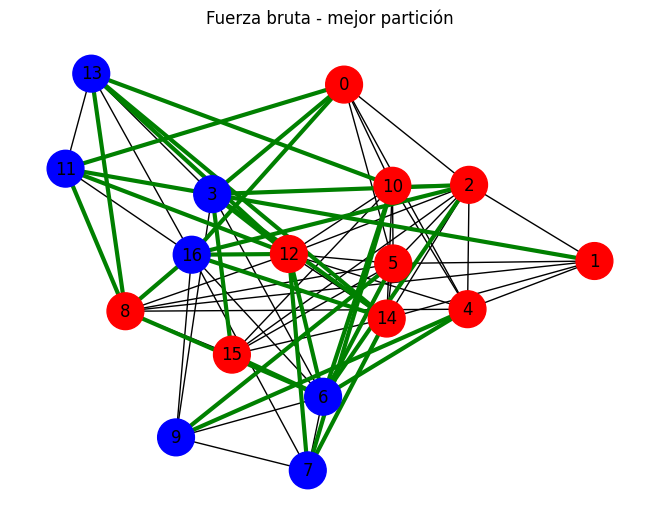

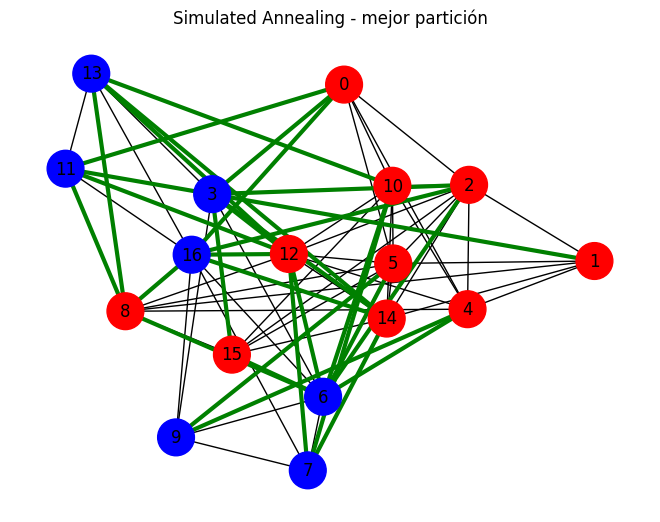

In [ ]:
def plot_partition(G, sample, pos, title):
    colors = ['red' if sample[node] == 1 else 'blue' for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=700)
    cut_edges = [(u, v) for u, v in G.edges() if sample[u] != sample[v]]
    nx.draw_networkx_edges(G, pos, edgelist=cut_edges, edge_color='green', width=3)
    plt.title(title)
    plt.show()

plot_partition(G, best_sample_brute, pos, "Fuerza bruta - mejor partición")
plot_partition(G, best_sample_sas, pos, "Simulated Annealing - mejor partición")


## Comentarios finales

El ajuste adecuado de los parámetros $A$, $B$ y $C$ es esencial para obtener soluciones viables y bien balanceadas.

El coste computacional crece rápidamente con el número de nodos, haciendo recomendable utilizar técnicas heurísticas para casos reales.

Esta memoria permite un análisis comprensivo y reproducible de la optimización con restricciones en modelos QUBO.
